In [1]:
from mpcrl import MPCenv, make_config
from py_wake.examples.data.hornsrev1 import V80
import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
DT_ENV = 30
DT_SIM = 10
YAW_RATE = 0.3
env = MPCenv(config=make_config(),
                turbine=V80(),  # e.g., IEA37/DTU10MW WT from PyWake
                x_pos=np.array([0, 500, 1000]),  # x positions of the turbines
                y_pos=np.array([0, 0, 0]),      # y positions of the turbines
                ws_scaling_min=5, ws_scaling_max=15,  # wind speed scaling
                wd_scaling_min=250, wd_scaling_max=290,  # wind direction scaling
                ti_scaling_min=0.00, ti_scaling_max=0.15,  # turbulence intensity scaling
                turbtype="None",
                dt_env=DT_ENV,
                dt_sim=DT_SIM,
                yaw_step_sim=DT_SIM*YAW_RATE,  # 10 sim step * 0.3 (yaw actuation time)
                yaw_init='Zeros',

                )

Steady state steps: 11.0


In [3]:
obs, info = env.reset()


powers_plot = []
yaws_plot = []
time_plot = []
time_plot_coarse = []
wd_belief_plot = []
ws_belief_plot = []
TI_belief_plot = []

for _ in range(15):
    action = env.action_space.sample()

    obs, reward, terminated, truncated,  info = env.step(env.action_space.sample())

    powers_plot.append(info["powers"].sum(axis=1))
    time_plot.append(info["time_array"])
    yaws_plot.append(info["yaws"])
    
    wd_belief_plot.append(info["estimated_wd"])
    ws_belief_plot.append(info["estimated_ws"])
    TI_belief_plot.append(info["estimated_TI"])

    time_plot_coarse.append(copy.copy(env.fs.time))


Steady state steps: 10.0


In [4]:
time_plot = np.concatenate(time_plot)
powers_plot = np.concatenate(powers_plot)
yaws_plot = np.concatenate(yaws_plot)

wd_belief_plot = np.array(wd_belief_plot).squeeze()
ws_belief_plot = np.array(ws_belief_plot).squeeze()
TI_belief_plot = np.array(TI_belief_plot).squeeze()
time_plot_coarse = np.array(time_plot_coarse)

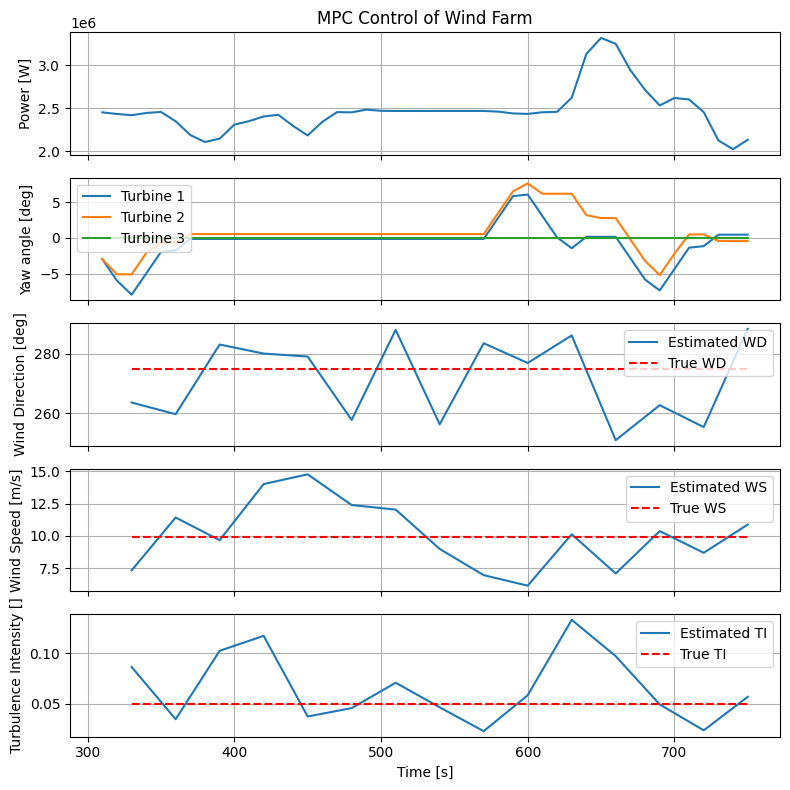

In [5]:
fig, ax = plt.subplots(5,1, figsize=(8,8), sharex=True)

ax[0].plot(time_plot, powers_plot)
ax[0].set_ylabel("Power [W]")
ax[0].set_title("MPC Control of Wind Farm")
ax[0].grid()

ax[1].plot(time_plot, yaws_plot)
ax[1].set_ylabel("Yaw angle [deg]")

ax[1].legend([f"Turbine {i+1}" for i in range(yaws_plot.shape[1])])
ax[1].grid()


ax[2].plot(time_plot_coarse, wd_belief_plot, label='Estimated WD')
ax[2].set_ylabel("Wind Direction [deg]")
ax[2].hlines(env.wd, time_plot_coarse[0], time_plot_coarse[-1], colors='r', linestyles='dashed', label='True WD')
ax[2].grid()
ax[2].legend()

ax[3].plot(time_plot_coarse, ws_belief_plot, label='Estimated WS')
ax[3].set_ylabel("Wind Speed [m/s]")
ax[3].hlines(env.ws, time_plot_coarse[0], time_plot_coarse[-1], colors='r', linestyles='dashed', label='True WS')
ax[3].grid()
ax[3].legend()

ax[4].plot(time_plot_coarse, TI_belief_plot, label='Estimated TI')
ax[4].set_ylabel("Turbulence Intensity []")
ax[4].hlines(env.ti, time_plot_coarse[0], time_plot_coarse[-1], colors='r', linestyles='dashed', label='True TI')
ax[4].grid()
ax[4].legend()

ax[-1].set_xlabel("Time [s]")
plt.tight_layout()
plt.show()


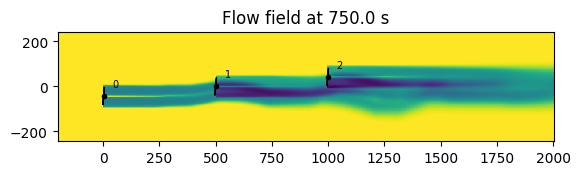

In [6]:
env.plot_farm()